In [1]:
import autograd.numpy as np
from autograd import grad
from autograd.numpy import linalg, dot
from autograd.numpy.random import multivariate_normal, normal
%matplotlib inline
from matplotlib import pyplot as plt

from ChainNode import ChainNode
from Neighbour import Neighbour 

In [2]:
#initialise parameters
N = 10 # Number of iterations
M = 2 # dimensionality of state
L = 2 # dimensionality of output
e = 1e-5 # convergence condition

#Kalman Parameters, linear motion estimation
t_s = 0.1 # sample period
s_p = 1 # process noise variance
s_m = 0.1 # measurement noise variance

#model parameters
A = np.asarray([[1,t_s],[0,1]]) # state transition
B = np.asarray([[np.power(t_s,2)/2],[t_s]]) # noise matrix
C = np.asarray([[0,1]]) # observation matrix
Q = np.asarray([[s_p/64,s_p/16],[s_p/16,s_p/4]]) # Process noise Covariance
R = np.asarray([[s_m]])

#state variables
u = normal(0,s_p,[1,1]).T
z = np.asarray([[1],[1]]) # initial statev
v = normal(0,s_m)
y = np.dot(C,z) + v #initial output

#Kalman filter variables 
P_post = Q
z_post = normal(0,1,[2,1])
z_post = z

#PDMM Parameters
Z = z # state history
U = u # noise history
Y = y # output history

Z_post = z_post #posterior estimate history

# E = linalg.inv(np.block([[Q,np.zeros(M,M)],[np.zeros([M,M]),R]]))
p = 0.001 #step size

In [3]:
# Run kalman simulation
for i in range(N):
    
    z_prior = dot(A,z_post) 
    P_prior = dot(A,dot(P_post,A.T)) + Q
    
    u = normal(0,s_p)
    v = normal(0,s_m)
    z = np.dot(A,z) + np.dot(B,u)
    y = np.dot(C,z) + v
    
    #Perform Kalman filtering, General equation needed for numerical stability
    K_int = 1/(dot(C,dot(P_prior,C.T)) + R )
    K = dot(P_prior,K_int*C.T)
    z_post = z_prior + dot(K,(y - dot(C,z_prior)))
    P_int = np.eye(2) - dot(L,C)
    P_post = dot(dot(P_int,P_prior),P_int.T) + dot(K,dot(R,K.T))
    
    #add new information to history
    Z = np.append(Z,z,axis=1)
    Z_post = np.append(Z_post,z_post,axis=1)
    U = np.append(U,u)
    Y = np.append(Y,y)

In [4]:
# Initialise PDMM Graph

Q_inv = linalg.pinv(Q)
R_int = dot(C,(C/R).T)
P_inv = linalg.inv(P_post)

N_dim = 3
msg_dim = 2
E = np.block([[Q_inv,np.zeros([2,1])],[np.zeros([1,2]),R_int]])
# E_0 = np.block([[Q_inv,np.zeros([2,1])],[np.zeros([1,2]),R_int + P_inv]]), 
#consider funniness introduced by degenerate Q value and pseudoinverses
a_0 = np.block([[np.zeros([1,1])],[dot(Y[0],dot(1/R,C)).T]])

G = [ChainNode(0,N_dim,E,a_0)] 

#initialise nodes
for i in np.arange(N-1)+1:
    a_i = np.block([[np.zeros([1,1])],[dot(Y[i],dot(1/R,C)).T]])
    G.append(ChainNode(i,N_dim,E,a_i))

c_ij = np.zeros([2,1]) 
    
#insert forward neighbours
A_forward = np.block([-B,-A])
for i in np.arange(N-1):
    P_ij = dot(A_forward,dot(linalg.pinv(G[i].E),A_forward.T))
    neighbour = Neighbour(G[i+1],i+1,A_forward,c_ij,P_ij,msg_dim)
    G[i].Neighbours.append(neighbour)

#insert backward neighbours 
A_backward = np.block([np.zeros([2,1]),np.eye(2)])
for i in np.arange(N-1)+1:
    P_ij = dot(A_backward,dot(linalg.pinv(G[i].E),A_backward.T))
    neighbour = Neighbour(G[i-1],i-1,A_backward,c_ij,P_ij,msg_dim)
    G[i].Neighbours.append(neighbour)
    

In [5]:
# Run Synchronous PDMM
N_iter = 50
for i in range(N_iter):
    print(i)
    for node in G:
        node.update()

    for node in G:
        node.finalise()

0
1 9.67358732637e-05
5000 0.000123381111051
5000 0.000191012161953
3957 9.99982864793e-05
5000 0.000128980090929
5000 0.000122618881613
5000 0.000158235693001
1 3.39415414005e-05
1 1.52689555587e-05
5000 0.000162756670576
1
99 9.99938293506e-05
2410 9.99934854932e-05
5000 0.000117591644744
1 9.16457202513e-05
2839 9.99968486889e-05
1839 9.99939956776e-05
4786 9.99972521148e-05
1 2.97548806544e-05
1 2.31891864178e-05
5000 0.000103530285566
2
1 9.91226077727e-05
1711 9.99973271099e-05
2163 9.99978461467e-05
1 9.79268905429e-05
811 9.9995807789e-05
217 9.99928555011e-05
1 9.9500451201e-05
1 3.85188632892e-05
1 1.9268740187e-05
545 9.9991403062e-05
3
332 9.99975038256e-05
1 9.80674901671e-05
1 9.81260095828e-05
1 9.05383414432e-05
1 9.93814170537e-05
1 9.78252763664e-05
166 9.99961595344e-05
1 3.42846845023e-05
1 2.63082516666e-05
369 9.99993232621e-05
4
1 9.94246983403e-05
1557 9.99955631435e-05
223 9.99981860255e-05
1 9.67524771739e-05
782 9.99919598951e-05
55 9.99931354749e-05
1 9.9496

504 9.99970408733e-05
245 9.99988471614e-05
405 9.99978715191e-05
39
29 9.99974087082e-05
1 9.72361125224e-05
18 9.99921610116e-05
1 9.5373337787e-05
1 9.94051549665e-05
41 9.99970856534e-05
142 9.99924048764e-05
1 9.62600462251e-05
1 9.95326856812e-05
1 9.9472523662e-05
40
144 9.99993647053e-05
138 9.99938164021e-05
101 9.99907572565e-05
183 9.99943736524e-05
10 9.99976708301e-05
155 9.99974429595e-05
1 9.99426845309e-05
482 9.99934022696e-05
178 9.99972207815e-05
338 9.99965359022e-05
41
22 9.99951589324e-05
1 9.71810084959e-05
10 9.99995436752e-05
1 9.5344693822e-05
1 9.9401578382e-05
41 9.99989011285e-05
136 9.99907092993e-05
1 9.63422406874e-05
1 9.949131063e-05
1 9.93791385849e-05
42
142 9.9998522021e-05
118 9.99988208971e-05
107 9.99977688886e-05
174 9.99935093586e-05
3 9.99993330461e-05
127 9.99979340275e-05
1 9.99835086977e-05
455 9.99982446583e-05
131 9.99975900658e-05
283 9.99989892558e-05
43
15 9.99948834354e-05
1 9.71338965277e-05
4 9.99945994523e-05
1 9.53233826095e-05
1 

In [6]:
#collect messages
Z_pdmm = []
for i in range(N):
    Z_pdmm.append(G[i].Neighbours[0].m_ij)
Z_pdmm = np.asarray(Z_pdmm).reshape(10,2)

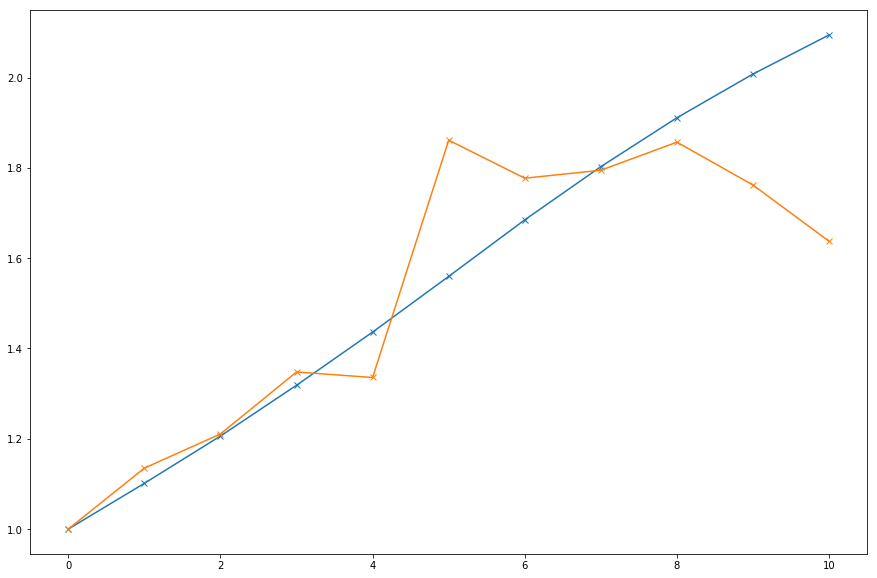

In [9]:
plt.figure(figsize=(15,10))
plt.plot(Z[0,:],'x-')
plt.plot(Z_post[0,:],'x-')
#plt.plot(Z_pdmm[:,0],'x-')